# HW4P2: Attention-based Speech Recognition

<img src="https://cdn.shopify.com/s/files/1/0272/2080/3722/products/SmileBumperSticker_5400x.jpg" alt="A cute cat" width="600">


Welcome to the final assignment in 11785. In this HW, you will work on building a speech recognition system with <i>attention</i>. <br> <br>

<center>
<img src="https://popmn.org/wp-content/uploads/2020/03/pay-attention.jpg" alt="A cute cat" height="100">
</center>

HW Writeup: [TODO] <br>
Kaggle Competition Link: https://www.kaggle.com/competitions/attention-based-speech-recognition <br>
Kaggle Dataset Link: https://www.kaggle.com/competitions/attention-based-speech-recognition/data
<br>
LAS Paper: https://arxiv.org/pdf/1508.01211.pdf <br>
Attention is all you need:https://arxiv.org/pdf/1706.03762.pdf

# Read this section importantly!

1. By now, we believe that you are already a great deep learning practitioner, Congratulations. 🎉

2. You are allowed to use code from your previous homeworks for this homework. We will only provide, aspects that are necessary and new with this homework.

3. There are a lot of resources provided in this notebook, that will help you check if you are running your implementations correctly.

In [3]:
!nvidia-smi

Fri Dec  1 06:37:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   30C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Install some required libraries
# Feel free to add more if you want
!pip install -q python-levenshtein torchsummaryX wandb kaggle pytorch-nlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 15.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 39.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 252.8/252.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.7 MB/s eta 0:00:00


In [5]:
import torch
import torchaudio
from torch import nn, Tensor
# import torchsummary
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

import numpy as np
import os
import pdb

import gc
import time

import pandas as pd
from tqdm.notebook import tqdm as blue_tqdm
import matplotlib.pyplot as plt
import seaborn
import json

import math
from typing import Optional, List
from tqdm import tqdm


#imports for decoding and distance calculation
try:
    import wandb
    import torchsummaryX
    import Levenshtein
except:
    print("Didnt install some/all imports")

import warnings
warnings.filterwarnings('ignore')

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


# Config

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

root = '/content/11-785-f23-hw4p2'

Mounted at /content/gdrive


In [7]:
config = dict (
    train_dataset       = 'train-clean-100', # train-clean-100, train-clean-360, train-clean-460
    batch_size          = 128,
    epochs              = 100,
    init_lr             = 2e-4,
    weight_decay        = 5e-3,
    cephstral_norm      = True,
)

# Kaggle Dataset Download

In [8]:
!pip install --upgrade --force-reinstall --no-deps kaggle==1.5.8
!mkdir /root/.kaggle

with open("/root/.kaggle/kaggle.json", "w+") as f:
    f.write('{"username":"sushanthjayanth","key":""}')
    # Put your kaggle username & key here

!chmod 600 /root/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.8-py3-none-any.whl size=73249 sha256=f35026bba7848aefc552c92752409d99be903d8d2d9a840486ac6176301ef4e0
  Stored in directory: /root/.cache/pip/wheels/0b/76/ca/e58f8afa83166a0e68f0d5cd2e7f99d260bdc40e35da080eee
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [9]:
# # to download the dataset
!kaggle competitions download -c attention-based-speech-recognition

# # to unzip data quickly and quietly
!unzip -q attention-based-speech-recognition.zip -d ./data

100% 16.6G/16.6G [07:09<00:00, 41.6MB/s]
100% 16.6G/16.6G [07:09<00:00, 41.5MB/s]


# Character-based LibriSpeech (HW4P2)

In terms of the dataset, the dataset structure for HW3P2 and HW4P2 dataset are very similar. Can you spot out the differences? What all will be required??

Hints:

- Check how big is the dataset (do you require memory efficient loading techniques??)
- How do we load mfccs? Do we need to normalise them?
- Does the data have \<SOS> and \<EOS> tokens in each sequences? Do we remove them or do we not remove them? (Read writeup)
- Would we want a collating function? Ask yourself: Why did we need a collate function last time?
- Observe the VOCAB, is the dataset same as HW3P2?
- Should you add augmentations, if yes which augmentations? When should you add augmentations? (Check bootcamp for answer)


In [10]:
VOCAB = [
    '<pad>', '<sos>', '<eos>',
    'A',   'B',    'C',    'D',
    'E',   'F',    'G',    'H',
    'I',   'J',    'K',    'L',
    'M',   'N',    'O',    'P',
    'Q',   'R',    'S',    'T',
    'U',   'V',    'W',    'X',
    'Y',   'Z',    "'",    ' ',
]

# creating the map
VOCAB_MAP = {VOCAB[i]:i for i in range(0, len(VOCAB))}

PAD_TOKEN = VOCAB_MAP["<pad>"]
SOS_TOKEN = VOCAB_MAP["<sos>"]
EOS_TOKEN = VOCAB_MAP["<eos>"]

print(f"Length of vocab : {len(VOCAB)}")
print(f"Vocab           : {VOCAB}")
print(f"PAD_TOKEN       : {PAD_TOKEN}")
print(f"SOS_TOKEN       : {SOS_TOKEN}")
print(f"EOS_TOKEN       : {EOS_TOKEN}")

Length of vocab : 31
Vocab           : ['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ']
PAD_TOKEN       : 0
SOS_TOKEN       : 1
EOS_TOKEN       : 2


In [11]:
class SpeechDatasetME(torch.utils.data.Dataset): # Memory efficient
    # Loades the data in get item to save RAM

    def __init__(self, root, partition= "train-clean-360", transforms = None, cepstral=True):

        self.VOCAB      = VOCAB
        self.cepstral   = cepstral
        self.transforms = transforms

        mfcc_file_paths = None
        transcript_file_paths = None

        # train using only train-100 or train-360
        # NOTE: INCLUDING VALIDATION SET HERE TOO
        if partition == "train-clean-100" or partition == "train-clean-360" or partition == "dev-clean":
            mfcc_dir       = os.path.join(root, partition, "mfcc")
            transcript_dir = os.path.join(root, partition, "transcripts")

            mfcc_file_names        = sorted(os.listdir(mfcc_dir))
            transcript_file_names  = sorted(os.listdir(transcript_dir))
            assert len(mfcc_file_names) == len(transcript_file_names)

            mfcc_file_paths = [os.path.join(mfcc_dir, file_name) for file_name in mfcc_file_names]
            transcript_file_paths = [os.path.join(transcript_dir, file_name) for file_name in mfcc_file_names]

        else:
            mfcc_dir_1       = os.path.join(root, "train-clean-100", "mfcc")
            transcript_dir_1 = os.path.join(root, "train-clean-100", "transcripts")

            mfcc_file_names_1        = sorted(os.listdir(mfcc_dir_1))
            transcript_file_names_1  = sorted(os.listdir(transcript_dir_1))

            mfcc_dir_2       = os.path.join(root, "train-clean-100", "mfcc")
            transcript_dir_2 = os.path.join(root, "train-clean-100", "transcripts")

            # add the list of mfcc and transcript paths from train-clean-360 to the list of paths  from train-clean-100
            mfcc_file_names_2        = sorted(os.listdir(mfcc_dir_2))
            transcript_file_names_2  = sorted(os.listdir(transcript_dir_2))

            assert len(mfcc_file_names_1) == len(transcript_file_names_1)
            assert len(mfcc_file_names_2) == len(transcript_file_names_2)

            mfcc_file_paths_1 = [os.path.join(mfcc_dir_1, file_name) for file_name in mfcc_file_names_1]
            transcript_file_paths_1 = [os.path.join(transcript_dir_1, file_name) for file_name in mfcc_file_names_1]

            mfcc_file_paths_2 = [os.path.join(mfcc_dir_2, file_name) for file_name in mfcc_file_names_2]
            transcript_file_paths_2 = [os.path.join(transcript_dir_2, file_name) for file_name in mfcc_file_names_2]

            mfcc_file_paths = mfcc_file_paths_1 + mfcc_file_paths_2
            transcript_file_paths = transcript_file_paths_1 + transcript_file_paths_2

        length = len(mfcc_file_paths)
        mfcc_files = []
        transcript_files = []

        # load the mfcc and transcript files
        for i in range(len(mfcc_file_paths)):
            # Load a single mfcc
            mfcc = np.load(mfcc_file_paths[i])
            mfcc_files.append(mfcc)
            transcript  = np.load(transcript_file_paths[i])
            transcript_files.append(transcript[1:-1])

        # convert transcript files from char or string to int using VOCAB_MAP
        vocab_lambda = lambda x: VOCAB_MAP[x]
        transcript_files = [np.array(list(map(vocab_lambda, x))) for x in transcript_files]

        self.mfcc_files         = mfcc_files
        self.transcript_files   = transcript_files
        self.length             = len(transcript_files)
        print("Loaded file paths ME: ", partition)


    def __len__(self):
        return self.length

    def __getitem__(self, ind):

        # Load the mfcc and transcripts from the mfcc and transcript paths created earlier
        mfcc = self.mfcc_files[ind]
        transcript = self.transcript_files[ind]

        # cephstral normalization
        mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1e-8)

        return (torch.FloatTensor(mfcc), torch.LongTensor(transcript))

    def collate_fn(self,batch):

        batch_x, batch_y, lengths_x, lengths_y = [], [], [], []

        for x, y in batch:
            # Add the mfcc, transcripts and their lengths to the lists created above
            batch_x.append(x)
            batch_y.append(y)
            lengths_x.append(len(x))
            lengths_y.append(len(y))

        # pack the mfccs and transcripts using the pad_sequence function from pytorch
        batch_x_pad = pad_sequence(batch_x, batch_first=True, padding_value=0)
        batch_y_pad = pad_sequence(batch_y, batch_first=True, padding_value=0)

        return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)


In [12]:
class SpeechDatasetTest(torch.utils.data.Dataset):

    def __init__(self, root, partition, cepstral=False):

        self.mfcc_dir   = os.path.join(root, partition, "mfcc")
        self.mfcc_file_names = sorted(os.listdir(self.mfcc_dir))

        self.mfccs = []
        for i, filename in enumerate(blue_tqdm(self.mfcc_file_names)):
            mfcc = np.load(os.path.join(self.mfcc_dir, filename))
            if cepstral:
                # Normalize the mfccs
                mfcc = (mfcc - np.mean(mfcc, axis=0)) / (np.std(mfcc, axis=0) + 1e-8)
            # append the mfcc to the mfcc list created earlier
            self.mfccs.append(mfcc)

        self.length = len(self.mfccs)

        print("Loaded: ", partition)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        return torch.FloatTensor(self.mfccs[ind])

    def collate_fn(self,batch):

        batch_x, lengths_x = [], []
        for x in batch:
            # Append the mfccs and their lengths to the lists created above
            batch_x.append(x)
            lengths_x.append(len(x))

        # pack the mfccs using the pad_sequence function from pytorch
        batch_x_pad = pad_sequence(batch_x, batch_first=True, padding_value=0)

        return batch_x_pad, torch.tensor(lengths_x)

In [13]:
DATA_DIR        = '/content/data/11-785-f23-hw4p2'
PARTITION       = config['train_dataset']
CEPSTRAL        = config['cephstral_norm']

train_dataset   = SpeechDatasetME(
    root        = DATA_DIR,
    partition   = PARTITION,
    cepstral    = CEPSTRAL
)
valid_dataset   = SpeechDatasetME(
    root        = DATA_DIR,
    partition   = 'dev-clean',
    cepstral    = CEPSTRAL
)
test_dataset    = SpeechDatasetTest(
    root        = DATA_DIR,
    partition   = 'test-clean',
    cepstral    = CEPSTRAL,
)

gc.collect()

Loaded file paths ME:  train-clean-100
Loaded file paths ME:  dev-clean


  0%|          | 0/2620 [00:00<?, ?it/s]

Loaded:  test-clean


207

In [14]:
train_loader    = torch.utils.data.DataLoader(
    dataset     = train_dataset,
    batch_size  = config['batch_size'],
    shuffle     = True,
    num_workers = 4,
    pin_memory  = True,
    collate_fn  = train_dataset.collate_fn
)

valid_loader    = torch.utils.data.DataLoader(
    dataset     = valid_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = valid_dataset.collate_fn
)

test_loader     = torch.utils.data.DataLoader(
    dataset     = test_dataset,
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2,
    pin_memory  = True,
    collate_fn  = test_dataset.collate_fn
)

print("No. of train mfccs   : ", train_dataset.__len__())
print("Batch size           : ", config['batch_size'])
print("Train batches        : ", train_loader.__len__())
print("Valid batches        : ", valid_loader.__len__())
print("Test batches         : ", test_loader.__len__())

No. of train mfccs   :  28539
Batch size           :  96
Train batches        :  298
Valid batches        :  29
Test batches         :  28


In [15]:
print("\nChecking the shapes of the data...")
for batch in train_loader:
    x, y, x_len, y_len = batch
    print(x.shape, y.shape, x_len.shape, y_len.shape)
    print(y)
    break


Checking the shapes of the data...
torch.Size([96, 1664, 28]) torch.Size([96, 292]) torch.Size([96]) torch.Size([96])
tensor([[ 3,  9,  3,  ...,  0,  0,  0],
        [11, 30, 10,  ...,  0,  0,  0],
        [23, 16,  5,  ...,  0,  0,  0],
        ...,
        [22, 17, 30,  ...,  0,  0,  0],
        [17, 20, 30,  ...,  0,  0,  0],
        [27, 17, 23,  ...,  0,  0,  0]])


In [16]:
def verify_dataset(dataset, partition= 'train-clean-100'):
    print("\nPartition loaded     : ", partition)
    if partition != 'test-clean':
        print("Max mfcc length          : ", np.max([data[0].shape[0] for data in dataset]))
        print("Avg mfcc length          : ", np.mean([data[0].shape[0] for data in dataset]))
        print("Max transcript length    : ", np.max([data[1].shape[0] for data in dataset]))
        print("Max transcript length    : ", np.mean([data[1].shape[0] for data in dataset]))
    else:
        print("Max mfcc length          : ", np.max([data.shape[0] for data in dataset]))
        print("Avg mfcc length          : ", np.mean([data.shape[0] for data in dataset]))

verify_dataset(train_dataset, partition= 'train-clean-100')
verify_dataset(valid_dataset, partition= 'dev-clean')
verify_dataset(test_dataset, partition= 'test-clean')
dataset_max_len  = max(
    np.max([data[0].shape[0] for data in train_dataset]),
    np.max([data[0].shape[0] for data in valid_dataset]),
    np.max([data.shape[0] for data in test_dataset])
)
print("\nMax Length: ", dataset_max_len)


Partition loaded     :  train-clean-100
Max mfcc length          :  2448
Avg mfcc length          :  1264.6258453344547
Max transcript length    :  398
Max transcript length    :  184.65321139493324

Partition loaded     :  dev-clean
Max mfcc length          :  3260
Avg mfcc length          :  713.3570107288198
Max transcript length    :  516
Max transcript length    :  106.71698113207547

Partition loaded     :  test-clean
Max mfcc length          :  3491
Avg mfcc length          :  738.2206106870229

Max Length:  3491


Check if you are loading the data correctly with the following:

- Train Dataset
```
Partition loaded:  train-clean-100
Max mfcc length:  2448
Average mfcc length:  1264.6258453344547
Max transcript:  400
Average transcript length:  186.65321139493324
```

- Dev Dataset
```
Partition loaded:  dev-clean
Max mfcc length:  3260
Average mfcc length:  713.3570107288198
Max transcript:  518
Average transcript length:  108.71698113207547
```

- Test Dataset
```
Partition loaded:  test-clean
Max mfcc length:  3491
Average mfcc length:  738.2206106870229
```

If your values is not matching, read hints, think what could have gone wrong. Then approach TAs.

NOTE:
**Final Shape from Data Loaders for every batch should be:
(batch_size, seq_len, projection_size)**

# THE MODEL

### Listen, Attend and Spell
Listen, Attend and Spell (LAS) is a neural network model used for speech recognition and synthesis tasks.

- LAS is designed to handle long input sequences and is robust to noisy speech signals.
- LAS is known for its high accuracy and ability to improve over time with additional training data.
- It consists of an <b>listener, an attender and a speller</b>, which work together to convert an input speech signal into a corresponding output text.

#### The Dataflow:
<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/DataFlow.png" alt="data flow" height="100">
</center>

#### The Listener:
- converts the input speech signal into a sequence of hidden states.

#### The Attender:
- Decides how the sequence of Encoder hidden state is propogated to decoder.

#### The Speller:
- A language model, that incorporates the "context of attender"(output of attender) to predict sequence of words.






## Utils


In [17]:
class PermuteBlock(torch.nn.Module):
    def forward(self, x):
        return x.transpose(1, 2)

def plot_attention(attention):
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    seaborn.heatmap(attention, cmap='GnBu')
    plt.show()

def save_model(model, optimizer, scheduler, tf_scheduler, metric, epoch, path):
    torch.save(
        {'model_state_dict'         : model.state_dict(),
         'optimizer_state_dict'     : optimizer.state_dict(),
         'scheduler_state_dict'     : scheduler.state_dict(),
         'tf_scheduler'             : tf_scheduler,
         metric[0]                  : metric[1],
         'epoch'                    : epoch},
         path
    )

def load_model(best_path, epoch_path, model, mode= 'best', metric= 'valid_acc', optimizer= None, scheduler= None, tf_scheduler= None):


    if mode == 'best':
        checkpoint  = torch.load(best_path)
        print("Loading best checkpoint: ", checkpoint[metric])
    else:
        checkpoint  = torch.load(epoch_path)
        print("Loading epoch checkpoint: ", checkpoint[metric])

    model.load_state_dict(checkpoint['model_state_dict'], strict= False)

    if optimizer != None:
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #optimizer.param_groups[0]['lr'] = 1.5e-3
        optimizer.param_groups[0]['weight_decay'] = 1e-5
    if scheduler != None:
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if tf_scheduler != None:
        tf_scheduler    = checkpoint['tf_scheduler']

    epoch   = checkpoint['epoch']
    metric  = torch.load(best_path)[metric]

    return [model, optimizer, scheduler, tf_scheduler, epoch, metric]

class TimeElapsed():
    def __init__(self):
        self.start  = -1

    def time_elapsed(self):
        if self.start == -1:
            self.start = time.time()
        else:
            end = time.time() - self.start
            hrs, rem    = divmod(end, 3600)
            min, sec    = divmod(rem, 60)
            min         = min + 60*hrs
            print("Time Elapsed: {:0>2}:{:02}".format(int(min),int(sec)))
            self.start  = -1

class PositionalEncoding(torch.nn.Module):

    def __init__(self, projection_size, max_seq_len=176):
        super().__init__()
        # Read the Attention Is All You Need paper to learn how to code code the positional encoding

        self.n = 10000 # as per the Attention Is All You Need paper
        self.max_seq_len = max_seq_len
        self.d = projection_size
        self.encoding = np.zeros(shape=(self.max_seq_len, self.d))

        # Simple Code
        for t in range(1,self.max_seq_len):
          for i in np.arange(self.d/2):
            denominator = np.power(self.n, (2*i)/self.d)
            self.encoding[t, int(2*i)] = np.sin(t/denominator)
            self.encoding[t, int(2*i+1)] = np.cos(t/denominator)

        self.encoding = torch.as_tensor(self.encoding, device=DEVICE, dtype=torch.float16)

        # Optimized
        """
        def get_position_angle_vec(position):
            return [position / np.power(self.n, 2*(hid // 2) / self.d) for hid in range(self.d)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(self.max_seq_len)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        self.encoding = torch.FloatTensor(sinusoid_table).unsqueeze(0)
        """

    def forward(self, x):
        """
        Args:
              x : input shape (batch, seq_len, projection_size)

        Returns:
              x : input with added position encoding, (batch, seq_len, projection_size)
        """

        ############# Q. Is this the right way to add positional encoding?
        ############# Ans. Yes, you can add or concat apparently

        # Repeat the positional encoding along the batch dimension
        encoding_batch = self.encoding.unsqueeze(0).expand(x.size(0), -1, -1)

        # Add the positional encoding to the input tensor
        # print("input x shape is ", x.shape)
        # print("encoding shape is ", encoding_batch.shape)
        x = x + encoding_batch[:, :x.size(1), :]
        return x


## Modules

# Transformer Encoder

The generic encoder used in Attention Is All You Need, uses Multihead Self Attention
\


############# Q. Is the logic below correct?

The 'self' part of self attention stems from how we calculate the query:


\
query = self.QW @ x
key = self.KW @ x
value = self.VW @ x

As seen above, query is generated from the input embedding x itself (unlike decoder where we use the previous predicted token as the query

## Steps Invovled

1. The first sublayer implements a multi-head self-attention mechanism as explained in Lecture 19. The multi-head mechanism implements heads that receive a (different) linearly projected version of the queries, keys, and values, each to produce outputs in parallel that are then used to generate a final result.

2. The second sublayer is a fully connected feed-forward network consisting of  
   two linear transformations with Rectified Linear Unit (ReLU) activation in between.

   ```feedforward_NN = ReLU(W1x + b1)W2 + b2```

NOTE: We are using batchnorm instead of the layer norm here

In [18]:
class TransformerEncoder(torch.nn.Module):
    def __init__(self, projection_size, num_heads, dropout=0.3, forward_expansion=4):
        """
        Args:
            projection_size : (int) length of each embedding vector (generated for each token)
                  num_heads : (int) number of attention heads
                    dropout : (float) dropout probability used in nn.MultiheadAttention
          forward_expansion : (int) set to 4 in Attention Is All You Need

        NOTE: Here we're sticking with (input embedding vector shape = output shape)
        """
        super().__init__()

        # create the key, query and value weights
        """
        NOTE: At this stage we don't know what the seq_len or batch size will be
              and therefore will not be able to create the right shape tensor

              To overcome that, we'll just define the weights as a Linear layer
              This layer will no bias and will only work on projection size
        """
        self.KW = nn.Linear(projection_size, projection_size, bias=False)
        self.QW = nn.Linear(projection_size, projection_size, bias=False)
        self.VW = nn.Linear(projection_size, projection_size, bias=False)

        nn.init.xavier_normal_(self.KW.weight)
        nn.init.xavier_normal_(self.QW.weight)
        nn.init.xavier_normal_(self.VW.weight)

        self.permute = PermuteBlock()

        """
        NOTE: If we were implementing MultiHead Self attention ourselves, we would
              have to split the q, K, V which are obtained as:

              # orig K.shape = (projection_size, seq_len, batch)
              K = E @ W_k # where E = input token embedding
              V = E @ W_v
              q = D @ W_q # where D = last timestep's token prediciton from Decoder

              projection_per_head = projection_size / num_heads # (projection_size % num_heads) should be 0

              K = K.reshape(projection_per_head, num_heads, seq_len, batch_size)
              V = V.reshape(projection_per_head, num_heads, seq_len, batch_size)
              q = q.reshape(projection_per_head, num_heads, seq_len, batch_size)

        However, since we're using the torch.nn.MultiheadAttention directly,
        we don't need to do this splitting ourselves.
        """
        self.attention = nn.MultiheadAttention(embed_dim=projection_size,
                                                     num_heads=num_heads,
                                                     dropout=dropout)

        # self.bn1 = nn.BatchNorm1d(num_features=projection_size)
        # self.bn2 = nn.BatchNorm1d(num_features=projection_size)
        self.bn1 = nn.LayerNorm(projection_size)
        self.bn2 = nn.LayerNorm(projection_size)

        # Feed forward neural network
        self.MLP = torch.nn.Sequential(
            torch.nn.Linear(projection_size, projection_size*forward_expansion),
            torch.nn.ReLU(),
            torch.nn.Linear(projection_size*forward_expansion, projection_size)
        )

        for layer in self.MLP:
            if isinstance(layer, torch.nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        """
        Args:
                x : input tensor of shape (batch, seq_len, projection_size)

        Returns:
            out2 : transformed embedding vector which now has more contextual information
        """

        ############# Q. Layer norm okay here? And permuting the q,k,v for attention is fine?


        # compute the query, key, and value
        query   = self.QW(x)
        key     = self.KW(x)
        value   = self.VW(x)

        # Get shapes ready for MultiheadAttention
        """
        nn.MultiheadAttention expects query.shape = (L,N,E) = (seq_len, batch, projection_size) by default

        But we have query.shape = (batch, seq_len, projection_size)
        Therefore we permute again
        """
        query   = query.permute(1,0,2)
        key     = key.permute(1,0,2)
        value   = value.permute(1,0,2)

        out1, _ = self.attention(query, key, value)

        # repermute to get back to orig shape of (batch, seq_len, projection_size)
        out1    = out1.permute(1,0,2)

        # Create a residual connection between the input and the output of the attention module
        out1    = out1 + x

        # Get shapes ready for batchnorm
        """
        # out1.shape = (batch, seq_len, projection_size)

        But batchnorm1D works on the 'C' dimension of input tensor of shape (N,C,L)
        Here, C = projection size.

        If doing layer norm, it requires shape of (batch, ....)
        """
        # Apply batch norm to out1 # I'm doing layer norm instead
        out1    = self.bn1(out1)

        # Apply the output of the feed forward network
        out2    = self.MLP(out1)
        # Apply a residual connection between the input and output of the  FFN
        out2    = out2 + out1
        # Apply batch norm to the output
        out2    = self.bn2(out2)

        return out2

# Predefined, do not change
model  = TransformerEncoder(projection_size=128, num_heads=8).to(DEVICE)

print(model)

# should actually be (projection_size, batch, seq_len)
# but we have (projection_size, seq_len, batch)?
# x_sample    = torch.rand(128, 176, 256) # (projection_size, seq_len, batch)

############# Q. I'm assuming above was a mistake?

x_sample = torch.rand(256, 176, 128) # (batch, seq_len, projection_size)
torchsummaryX.summary(model, x_sample.to(DEVICE))
del x_sample

TransformerEncoder(
  (KW): Linear(in_features=128, out_features=128, bias=False)
  (QW): Linear(in_features=128, out_features=128, bias=False)
  (VW): Linear(in_features=128, out_features=128, bias=False)
  (permute): PermuteBlock()
  (attention): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
  )
  (bn1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (bn2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (MLP): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
  )
)
               Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                          
0_QW             [128, 128]  [256, 176, 128]  16.384k   16.384k
1_KW             [128, 128]  [256, 176, 128]  16.384k   16.384k
2_VW             [128, 128]  [256, 176, 128]  16.384k   16.384k
3_bn1               

## pBLSTM and it's dependency functions

In [19]:
class pBLSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(pBLSTM, self).__init__()

        # TODO: Initialize a single layer bidirectional LSTM with the given input_size and hidden_size
        self.blstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers=2, bidirectional=True, batch_first=True)

    def forward(self, x_packed): # x_packed is a PackedSequence

        x_padded, x_lengths = pad_packed_sequence(x_packed, batch_first=True)

        x_downsampled, x_lengths_downsampled = self.trunc_reshape(x_padded, x_lengths)

        x_packed_downsampled = pack_padded_sequence(x_downsampled, x_lengths_downsampled, batch_first=True, enforce_sorted=False)

        output, output_lens = self.blstm(x_packed_downsampled)

        return output


    def trunc_reshape(self, x, x_lens):
      # Check if you have an odd number of time steps
      if x.size(1) % 2 != 0:
          # Remove the last time step
          x = x[:, :-1, :]
          # Update the lengths array to reflect the change
          x_lens = [length - 1 for length in x_lens]

      # Reshape x to reduce the number of time steps by a downsampling factor while increasing the number of features
      x_reshaped = x.view(x.size(0), x.size(1) // 2, x.size(2) * 2)
      # Reduce lengths by the same downsampling factor
      x_lens_shortened = [length // 2 for length in x_lens]

      return x_reshaped, x_lens_shortened


class LockedDropout(nn.Module):
    def __init__(self):
        super().__init__()

        self.dropout = 0.4

    # assuming input is packed_seq
    def forward(self, x_packed):
        if not self.training or self.dropout==0.0:
            return x_packed

        x, x_lens = pad_packed_sequence(x_packed, batch_first=True)
        m = x.data.new(1, x.size(1), x.size(2)).bernoulli_(1 - self.dropout)
        mask = Variable(m, requires_grad=False) / (1 - self.dropout)
        mask = mask.expand_as(x)
        x = mask * x

        x_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)

        return x_packed

"""
class Encoder(torch.nn.Module):
    '''
    The Encoder takes utterances as inputs and returns latent feature representations
    '''
    def __init__(self, input_size, encoder_hidden_size):
        super(Encoder, self).__init__()

        self.stride = 1

        self.embedding = CustomResidualBlock(in_ch=input_size, out_ch=encoder_hidden_size, stride=self.stride)
        # self.embedding = torch.nn.Conv1d(in_channels=input_size, out_channels=encoder_hidden_size, kernel_size=3, stride=1, padding=1)
        self.locked_dropout = LockedDropout()
        self.permute = PermuteBlock()

        self.pBLSTMs = torch.nn.Sequential(
            pBLSTM(input_size=encoder_hidden_size*2, hidden_size=encoder_hidden_size),
            LockedDropout(),
            pBLSTM(input_size=encoder_hidden_size*4, hidden_size=encoder_hidden_size),
            LockedDropout(),
        )

        for layer in self.pBLSTMs.children():
            if isinstance(layer, pBLSTM):
                # Initialize the weights of the pBLSTM layer
                for name, param in layer.named_parameters():
                    if 'weight' in name:
                        torch.nn.init.xavier_normal(param)

    def forward(self, x, x_lens):
        x = self.permute(x)
        x = self.embedding(x)
        x = self.permute(x)
        x_packed = pack_padded_sequence(x, x_lens, batch_first=True, enforce_sorted=False)
        encoder_outputs = self.pBLSTMs(x_packed)
        encoder_outputs, encoder_lens = pad_packed_sequence(encoder_outputs, batch_first=True)

        return encoder_outputs, encoder_lens
"""

"\nclass Encoder(torch.nn.Module):\n    '''\n    The Encoder takes utterances as inputs and returns latent feature representations\n    '''\n    def __init__(self, input_size, encoder_hidden_size):\n        super(Encoder, self).__init__()\n\n        self.stride = 1\n\n        self.embedding = CustomResidualBlock(in_ch=input_size, out_ch=encoder_hidden_size, stride=self.stride)\n        # self.embedding = torch.nn.Conv1d(in_channels=input_size, out_channels=encoder_hidden_size, kernel_size=3, stride=1, padding=1)\n        self.locked_dropout = LockedDropout()\n        self.permute = PermuteBlock()\n\n        self.pBLSTMs = torch.nn.Sequential(\n            pBLSTM(input_size=encoder_hidden_size*2, hidden_size=encoder_hidden_size),\n            LockedDropout(),\n            pBLSTM(input_size=encoder_hidden_size*4, hidden_size=encoder_hidden_size),\n            LockedDropout(),\n        )\n\n        for layer in self.pBLSTMs.children():\n            if isinstance(layer, pBLSTM):\n         

## Listener

In [20]:
class TransformerListener(torch.nn.Module):

    def __init__(self,
                 input_size,
                 base_lstm_layers        = 1,
                 pblstm_layers           = 3,
                 listener_hidden_size    = 256,
                 n_heads                 = 8,
                 tf_blocks               = 1):
        super().__init__()

        # input to LSTM of shape (batch, seq_len, input_size)
        # create an lstm layer
        self.listener_hidden_size = listener_hidden_size
        self.listener_lstm_output_size = listener_hidden_size*2

        self.base_lstm = torch.nn.LSTM(input_size=input_size,
                                       hidden_size=listener_hidden_size,
                                       num_layers=base_lstm_layers,
                                       bidirectional=True, batch_first=True)

        for name, param in self.base_lstm.named_parameters():
          if 'weight' in name:
              nn.init.xavier_normal_(param)
          elif 'bias' in name:
              nn.init.constant_(param, 0.0)

        # NOTE: output of base_lstm will be : (batch_size, seq_len, hidden_size)
        # we need to permute so that Conv1D which takes (N, C_in, L_in) gets (batch, hidden_size, seq_len)

        ############# Q. How many Conv1d? Is this embedding layer where the factor of 8 reduction happens?
        # 3 conv1d correct

        # create a sequence of Conv1d layers (stack 3 of them to reduce seq_len by factor of 8, see writeup why factor of 8)
        # NOTE IMPORTANT: Input to Conv1d layer must be (batch_size, lstm_output_size, seq_len)
        self.embedding = nn.Sequential(
            nn.Conv1d(in_channels=self.listener_lstm_output_size, out_channels=self.listener_lstm_output_size, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(num_features=self.listener_lstm_output_size),
            nn.GELU(),
            nn.Conv1d(in_channels=self.listener_lstm_output_size, out_channels=self.listener_lstm_output_size, kernel_size=3, stride=2, padding=1),
            # nn.BatchNorm1d(num_features=listener_hidden_size),
            nn.GELU(),
            nn.Conv1d(in_channels=self.listener_lstm_output_size, out_channels=self.listener_lstm_output_size, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm1d(num_features=self.listener_lstm_output_size),
            nn.GELU(),
        )

        ####### Q2. What's the right way to do this?
        max_seq_len = 700
        # calculate the new output length using : output_shape = (input_shape + 2*padding - kernel)/(stride) + 1
        new_seq_len = lambda i: (i + 2*1 - 3)//2 + 1  # padding=1, kernel=3, stride=2
        reduced_seq_len = math.ceil(new_seq_len(new_seq_len(new_seq_len(max_seq_len))))

        # compute the postion encoding
        self.positional_encoding = PositionalEncoding(projection_size=(self.listener_lstm_output_size), max_seq_len=max_seq_len) ########### Q2. Try with the reduced seq_len

        # create a sequence of transformer blocks
        self.transformer_encoder = torch.nn.Sequential()

        ############# Q2. How do I figure out what this projection size should be? Should it just be listener_lstm_output_size?

        for i in range(tf_blocks):
            self.transformer_encoder.add_module(f"encoder_{i}", TransformerEncoder(projection_size=self.listener_lstm_output_size, num_heads=8))

        self.permute = PermuteBlock()

    def forward(self, x, x_len):

        ############# Q. Where should pBLSTM go?
        # Ans. pBLSTM not required, if really want to use it, add it after base_lstm and before embedding

        # pack the inputs before passing them to the LSTM
        # x.shape = (batch, seq_len, input_size)
        x_packed = pack_padded_sequence(x, x_len, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.base_lstm(x_packed)
        # unpack LSTM outputs
        output, output_lengths  = pad_packed_sequence(lstm_out, batch_first=True)

        # Pass the output through the embedding
        # output.shape = (batch, seq_len, 2*listener_hidden_size)
        output = self.permute(output)
        # output.shape = (batch, self.listener_lstm_output_size, seq_len)
        output = self.embedding(output)
        # output.shape = (batch, self.listener_lstm_output_size, seq_len_reduced) # here embedding output channels = listener_hidden_size
        output = self.permute(output)
        # output.shape = (batch, seq_len_reduced, self.listener_lstm_output_size)

        # calculate the new output length using : output_shape = (input_shape + 2*padding - kernel)/(stride) + 1
        new_seq_len = lambda i: (i + 2*1 - 3)//2 + 1  # padding=1, kernel=3, stride=2
        trial_out_len = new_seq_len(new_seq_len(new_seq_len(32)))
        output_lengths = new_seq_len(new_seq_len(new_seq_len(x_len)))

        # calculate the position encoding
        output  = self.positional_encoding(output)
        # Pass the output of the positional encoding through the transformer encoder
        # output.shape = (batch, seq_len_reduced, self.listener_lstm_output_size)
        output  = self.transformer_encoder(output)
        # output.shape = (batch, seq_len_reduced, projection_size) # here projection_size = self.listener_lstm_output_size

        return output, output_lengths

# Attention

### Different ways to compute Attention

1. Dot-product attention
    * raw_weights = bmm(key, query)
    * Optional: Scaled dot-product by normalizing with sqrt key dimension
    * Check "Attention is All You Need" Section 3.2.1
    * 1st way is what most TAs are comfortable with, but if you want to explore, check out other methods below


2. Cosine attention
    * raw_weights = cosine(query, key) # almost the same as dot-product xD

3. Bi-linear attention
    * W = Linear transformation (learnable parameter): d_k -> d_q
    * raw_weights = bmm(key @ W, query)

4. Multi-layer perceptron
    * Check "Neural Machine Translation and Sequence-to-sequence Models: A Tutorial" Section 8.4

5. Multi-Head Attention
    * Check "Attention is All You Need" Section 3.2.2
    * h = Number of heads
    * W_Q, W_K, W_V: Weight matrix for Q, K, V (h of them in total)
    * W_O: d_v -> d_v
    * Reshape K: (B, T, d_k) to (B, T, h, d_k // h) and transpose to (B, h, T, d_k // h)
    * Reshape V: (B, T, d_v) to (B, T, h, d_v // h) and transpose to (B, h, T, d_v // h)
    * Reshape Q: (B, d_q) to (B, h, d_q // h) `
    * raw_weights = Q @ K^T
    * masked_raw_weights = mask(raw_weights)
    * attention = softmax(masked_raw_weights)
    * multi_head = attention @ V
    * multi_head = multi_head reshaped to (B, d_v)
    * context = multi_head @ W_O

Pseudocode:

```python
class Attention:
    '''
    Attention is calculated using the key, value (from encoder embeddings) and query from decoder.

    After obtaining the raw weights, compute and return attention weights and context as follows.:

    attention_weights   = softmax(raw_weights)
    attention_context   = einsum("thinkwhatwouldbetheequationhere",attention, value) #take hint from raw_weights calculation

    At the end, you can pass context through a linear layer too.
    '''

    def init(listener_hidden_size,
              speller_hidden_size,
              projection_size):

        VW = Linear(listener_hidden_size,projection_size)
        KW = Linear(listener_hidden_size,projection_size)
        QW = Linear(speller_hidden_size,projection_size)

    def set_key_value(encoder_outputs):
        '''
        In this function we take the encoder embeddings and make key and values from it.
        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        '''
        key = KW(encoder_outputs)
        value = VW(encoder_outputs)
      
    def compute_context(decoder_context):
        '''
        In this function from decoder context, we make the query, and then we
         multiply the queries with the keys to find the attention logits,
         finally we take a softmax to calculate attention energy which gets
         multiplied to the generted values and then gets summed.

        key.shape   = (batch_size, timesteps, projection_size)
        value.shape = (batch_size, timesteps, projection_size)
        query.shape = (batch_size, projection_size)

        You are also recomended to check out Abu's Lecture 19 to understand Attention better.
        '''
        query = QW(decoder_context) #(batch_size, projection_size)

        raw_weights = #using bmm or einsum. We need to perform batch matrix multiplication. It is important you do this step correctly.
        #What will be the shape of raw_weights?

        attention_weights = #What makes raw_weights -> attention_weights

        attention_context = #Multiply attention weights to values

        return attention_context, attention_weights
```

## Scaled Dot Prod Attention Illustration

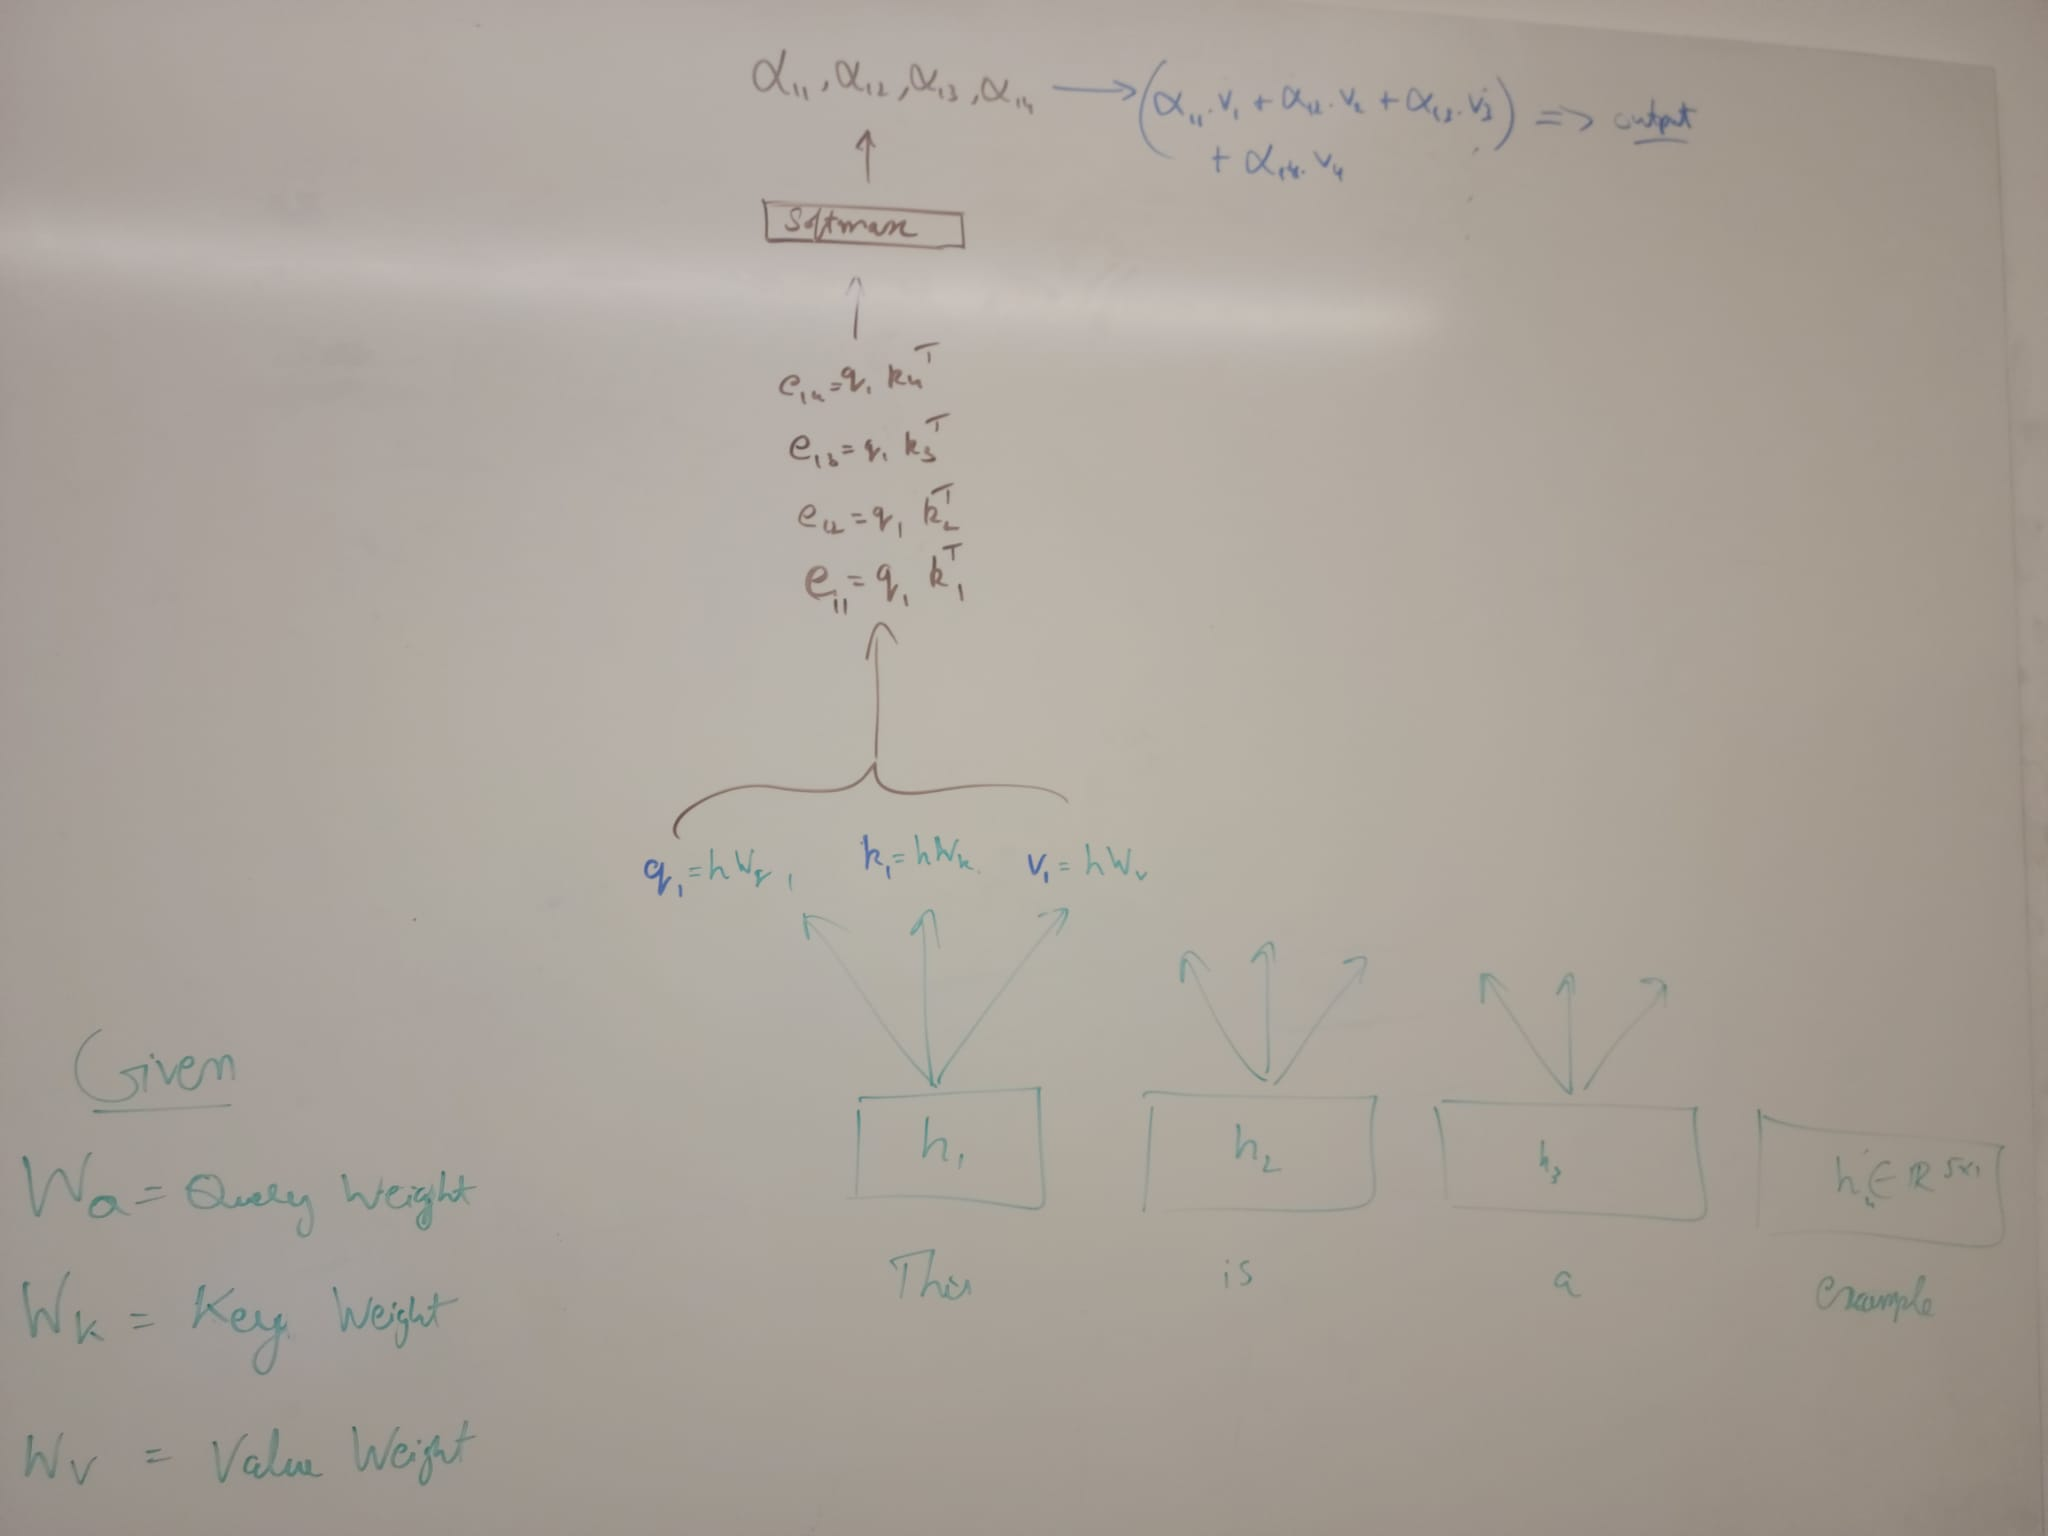

The above picture shows self attention, but here we'll be finding the query based on decoder output

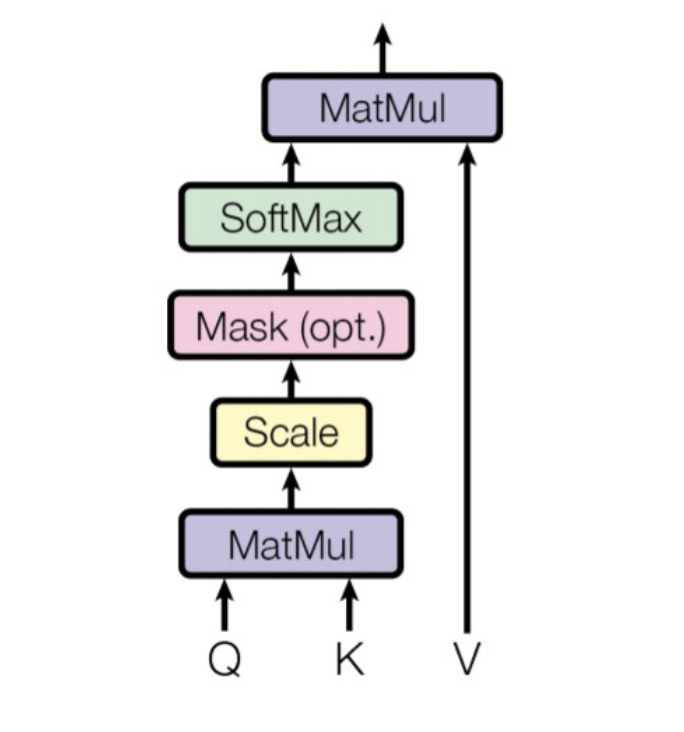

## Scaled Dot Prod Attention Implementation

In [21]:
class Attention(torch.nn.Module):
  def __init__(self, listener_hidden_size,
               speller_hidden_size,
               projection_size):
    super().__init__()
    self.KW = nn.Linear(listener_hidden_size, projection_size, bias=False)
    self.VW = nn.Linear(listener_hidden_size, projection_size, bias=False)
    self.QW = nn.Linear(speller_hidden_size, projection_size, bias=False)

    nn.init.xavier_normal_(self.KW.weight)
    nn.init.xavier_normal_(self.QW.weight)
    nn.init.xavier_normal_(self.VW.weight)

    self.projection_size = projection_size # for use in decoder later

  def set_key_value(self, encoder_outputs, encoder_lengths):
    """
    Args:
      encoder_outputs : (batch, timesteps, listener_hidden_size) -> NOTE: EACH
                        value of timesteps will be the max number of timesteps
                        for each item of the minibatch
                        (since all other smaller sequences will be padded to match seq len)
      encoder_lengths : (batch, 1, timesteps) -> NOTE: here each value in dim=1 will contain the seq_len of that batch

    Computes:
             self.key : (batch_size, timesteps, projection_size)
           self.value : (batch_size, timesteps, projection_size)
            self.mask : (batch_size, 1, seq_len) filled with boolean True/False

    References: https://stackoverflow.com/questions/53403306/how-to-batch-convert-sentence-lengths-to-masks-in-pytorch
    """
    self.key = self.KW(encoder_outputs) # (batch_size, timesteps, projection_size)
    self.value = self.VW(encoder_outputs) # (batch_size, timesteps, projection_size)
    self.mask = None

    max_num_timesteps = encoder_outputs.size(1) # FYI, max_num_timesteps = max_seq_len
    self.mask = (torch.arange(max_num_timesteps) < encoder_lengths.unsqueeze(1)).to(DEVICE)
    self.mask = self.mask.unsqueeze(1)
    # self.mask.shape = (batch_size, 1, timesteps)
    """
    Understanding the above line:

    encoder_lengths.shape = (batch_size, timesteps)
    required mask shape = raw_weights.shape = (batch, 1, timesteps)

    encoder_lenghts.unsqueeze(1) -> will give (batch, 1, timesteps) where each
    element in the last dimension will have the max len of that item in batch
    eg. encoder_lens[0,0,:] = [2,3,1] -> which means there are three sequences
                                       in each batch and the number of timesteps
                                       for the 1st batch is 2,3 and 1 respectively

    Now the torch.arange(max_seq_len) will mimic the encoder_outputs which are padded
    eg. range_tensor = torch.arage(3) = [0,1,2] # max_seq_len = 3 here

    result = range_tensor < encoder_lens[0,0,:]
    >> result
    >> [False, False, True]

    Further, for the remaining dimensions of batch and seq_len which the
    torch.arange tensor does not have, it will be broadcasted
    """

  def compute_context(self, decoder_context):
    """
    Args:
      decoder_context : previous timestep's hidden cell's value from decoder (batch_size, speller_hidden_size)

    Returns:
      attention_context: (batch_size, projection_size)
      attention_weights: (batch_size, timesteps)
    """
    query = self.QW(decoder_context) # query.shape = (batch_size, projection_size)
    query_unsqueezed = query.unsqueeze(1) # query.shape = (batch_size, projection_size, 1)

    # key.shape = # (batch_size, timesteps, projection_size)
    key_transposed = self.key.permute(0,2,1)
    # key.shape = # (batch_size, projection_size, timesteps)

    """
    the above shape changes are necessary because torch.bmm uses specific dimensions like:

    >>> input = torch.randn(10, 3, 4)
    >>> mat2 = torch.randn(10, 4, 5)
    >>> res = torch.bmm(input, mat2)
    >>> res.size()
    torch.Size([10, 3, 5])
    """

    # psuedocode => raw_weights = q @ K_T
    # shape     =  torch.bmm[ (batch_size, 1, projection_size), (batch_size, projection_size, timesteps) ]
    raw_weights = torch.bmm(query_unsqueezed, key_transposed) # raw_weights.shape = (batch, 1, timesteps)

    # scale down weights to prevents huge gradients during training
    raw_weights = raw_weights / (query.shape[-1] ** 0.5) # raw_weights.shape = (batch, 1, timesteps)

    # Apply mask to ensure that padded extras in each sequence don't contribute to context
    if self.mask is not None:
      # Ensure the mask has the correct datatype and dimensions
      mask = self.mask.to(raw_weights.dtype)
      raw_weights = raw_weights.masked_fill(mask == 0, -float('inf'))

    ############# Q. softmax dimension correct?

    # Apply softmax to get attention weights
    attention_weights = torch.softmax(raw_weights, dim=2)  # (batch_size, 1, timesteps)

    """
    atten = (batch_size, 1, timesteps)
    value = (batch_size, timesteps, projection_size)
    """
    attention_context = torch.einsum('bik,bkj->bij', attention_weights, self.value)  # (batch_size, 1, projection_size)

    # Squeeze to only get batch & sequence dimensions
    attention_context = attention_context.squeeze(1)  # (batch_size, projection_size)

    return attention_context, attention_weights.squeeze(1)

# The Speller

Similar to the language model that you coded up for HW4P1, you have to code a language model for HW4P2 as well. This time, we will also call the attention context step, within the decoder to get the attended-encoder-embeddings.


What you have coded till now:

<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/EncoderAttention.png" alt="data flow" height="400">
</center>

For the Speller, what we have to code:


<center>
<img src="https://github.com/varunjain3/11785_s23_h4p2/raw/main/Decoder.png" alt="data flow" height="400">
</center>

In [22]:
class LockedDropout(torch.nn.Module):
    def __init__(self, dropout_prob=0.3):
        super().__init__()

        self.dropout = dropout_prob
        self.mask = None

    # assuming input is packed_seq
    def forward(self, x):
        if not self.training or self.dropout==0.0:
            return x

        ######## Q2. Is this correct?
        if self.mask is None:
            m = x.data.new(x.size(0), x.size(1)).bernoulli_(1 - self.dropout)
            self.mask = torch.autograd.Variable(m, requires_grad=False) / (1 - self.dropout)
            # self.mask = x.new_empty(x.shape, requires_grad=False).bernoulli_(1 - self.dropout)
            # self.mask = self.mask / (1 - self.dropout)
            self.mask = self.mask.expand_as(x).to(DEVICE)

        x = self.mask * x

        return x

In [23]:
class Speller(torch.nn.Module):

  # Refer to your HW4P1 implementation for help with setting up the language model.
  # The only thing you need to implement on top of your HW4P1 model is the attention module and teacher forcing.

  def __init__(self, attender : Attention,
               max_timesteps, vocab_size, embedding_size,
               speller_hidden_size):
    """
    NOTE: vocab_size would be the original number of dimensions of one-hot vector format of our vocab
          embedding_size is the lower dimensional space to which we project our vocab space
    """
    super(). __init__()

    self.attend = attender # Attention object in speller
    self.max_timesteps = max_timesteps

    self.embedding = nn.Embedding(vocab_size, embedding_size, padding_idx=EOS_TOKEN)
    self.lstm_cells =  torch.nn.Sequential(
        torch.nn.LSTMCell(input_size=(self.attend.projection_size + embedding_size), hidden_size=speller_hidden_size),
        torch.nn.LSTMCell(input_size=speller_hidden_size, hidden_size=speller_hidden_size),
        torch.nn.LSTMCell(input_size=speller_hidden_size, hidden_size=speller_hidden_size),
        )

    self.locked_dropout_layer = LockedDropout(0.3)

    # CDN layers
    # NOTE: CDN gets concatenated input of (batch, speller_hidden_size) and (batch, attender_projection_size)
    self.output_to_char = nn.Linear(speller_hidden_size+attender.projection_size, embedding_size) # Linear module to convert outputs to correct hidden size (Optional: TO make dimensions match)
    self.activation = nn.ReLU() # Check which activation is suggested
    ######### Q2. embedding -> vocab size is a huge jump, is that okay?
    self.char_prob = nn.Linear(embedding_size, vocab_size) # Linear layer to convert hidden space back to logits for token classification
    self.char_prob.weight = self.embedding.weight # Weight tying (From embedding layer)


  def lstm_step(self, input_word, hidden_states_list):
    """
    Forward pass through each LSTMCell

    Args:
            input_word : (batch_size, embedding_size)
          hidden_state : output of LSTM = (hidden_state, prediction_output)

    Returns:
          hidden_state : output of LSTM = (hidden_state, prediction_output)
    """
    lstm_input = input_word

    """
    LSTM Cell Example

    >>> rnn = nn.LSTMCell(10, 20)  # (input_size, hidden_size)
    >>> input = torch.randn(2, 3, 10)  # (time_steps, batch, input_size)
    >>> hx = torch.randn(3, 20)  # (batch, hidden_size)
    >>> cx = torch.randn(3, 20)
    >>> output = []
    >>> for i in range(input.size()[0]):
    ...     hx, cx = rnn(input[i], (hx, cx))
    ...     output.append(hx)
    >>> output = torch.stack(output, dim=0)
    """

    ######### Q2. Is it okay to give LSTM 2D input?

    for i in range(len(self.lstm_cells)):
        hidden_state, cell_state = self.lstm_cells[i](lstm_input, hidden_states_list[i])
        hidden_states_list[i] = (hidden_state, cell_state)
        lstm_input = self.locked_dropout_layer(hidden_state) # prediction_out.shape = (batch_size, hidden_size)
        # lstm_input = hidden_state

    return hidden_state, hidden_states_list


  def CDN(self, cdn_input):
    # Make the CDN here, you can add the output-to-char
    return self.char_prob(self.activation(self.output_to_char(cdn_input)))


  def forward (self, y=None, teacher_forcing_ratio=1):
    """
    Args:
                y : labels of shape (batch, timesteps)
    Returns:
      raw_outputs : list of decoder predicted tokens (language model outputs)
        attn_plot : artifact of attention to visualize later

    Basic Flow:
    get_token_at_t-1 -> embedding_layer -> lstm layers ->
      -> use_lstm_hidden_to_get_attention_context -> combine lstm_hidden + context -> get_predicted_token
    """

    batch_size = config['batch_size']
    attn_context = torch.zeros(batch_size, self.attend.projection_size, device=DEVICE)  # initial context tensor for time t = 0
    output_symbol = torch.ones((batch_size,), dtype=torch.long, device=DEVICE) * SOS_TOKEN # Set it to SOS for time t = 0
    # NOTE: above output_symbol of shape (batch,) is equivalent to doing y[:, t]

    raw_outputs = []
    attention_plot = []

    ###### Q2. When is y=None? Val?
    if y is None:
      timesteps = self.max_timesteps
      teacher_forcing_ratio = 0.0 ############# Q. Why does it become zero?
                                          # Ans. just a hyperparam
    else:
      timesteps = y.size(1) # How many timesteps are we predicting for?

    # hidden states is a list whose len = num_lstm_cells. It just stores the LATEST hidden state of each lstm cell
    hidden_states_list = [None]*len(self.lstm_cells) # if hidden_states_list is None else hidden_states_list

    for t in range(timesteps):
      p = torch.rand(1).item()

      # Q. Why do we consider cases only when t > 0? What is considered when t == 0? Think.
      # Ans. When t=0 it's always SOS_TOKEN
      if p < teacher_forcing_ratio and t > 0:
        # Take from y, else draw from probability distribution
        output_symbol = y[:, t]

      # Embed the character symbol
      char_embed = self.embedding(output_symbol) # char_embed.shape = (batch, embedding_size)

      # Concatenate the character embedding and context from attention, as shown in the diagram
      lstm_input = torch.cat([char_embed, attn_context], dim=-1)

      prediction_out, hidden_states_list = self.lstm_step(lstm_input.squeeze(1), hidden_states_list)
      # hidden_states_list[i] = (output, hidden_state)
      latest_hidden_state = hidden_states_list[-1][-1]

      # latest_hidden_state.shape = (batch_size, speller_hidden_size)
      # attn_context.shape = (batch_size, projection_size)
      attn_context, attn_weights = self.attend.compute_context(latest_hidden_state)

      # concat latest_hidden_state + attn_context
      cdn_input = torch.cat([attn_context, latest_hidden_state], dim=1)

      # raw_pred.shape = (batch_size, vocab_size)
      raw_pred = self.CDN(cdn_input)

      # Generate a prediction for this timestep and collect it in output_symbols
      # output_symbol.shape = (batch_size, )
      output_symbol = torch.argmax(raw_pred, dim=-1, keepdim=True).squeeze(-1)

      raw_outputs.append(raw_pred) # for loss calculation
      attention_plot.append(attn_weights) # for plotting attention plot


    attention_plot = torch.stack(attention_plot, dim=1)
    raw_outputs = torch.stack(raw_outputs, dim=1)

    return raw_outputs, attention_plot

In [24]:
class ASRModel(torch.nn.Module):
  def __init__(self, input_size, listener_hidden_size,
               speller_hidden_size, projection_size,
               max_timesteps, vocab_size, embedding_size):
    super().__init__()

    # NOTE: Attender gets listenere_hidden_size*2 because of bLSTM (see Listener)
    self.listener = TransformerListener(input_size=input_size, listener_hidden_size=listener_hidden_size)
    self.attend = Attention(listener_hidden_size*2, speller_hidden_size, projection_size)
    self.speller = Speller(self.attend, max_timesteps, vocab_size, embedding_size, speller_hidden_size)

  def forward(self, x,lx,y=None,teacher_forcing_ratio=1):
    # Encode speech features
    encoder_outputs, encoder_lens = self.listener(x,lx)

    # We want to compute keys and values ahead of the decoding step, as they are constant for all timesteps
    # Set keys and values using the encoder outputs
    self.attend.set_key_value(encoder_outputs, encoder_lens)

    # Decode text with the speller using context from the attention
    raw_outputs, attention_plots = self.speller(y=y,teacher_forcing_ratio=teacher_forcing_ratio)

    return raw_outputs, attention_plots

# Model Setup

In [25]:
torch.cuda.empty_cache()
gc.collect()

26

In [26]:
"""
Understand the Shapes:

Listener:
  - input = (batch_size, seq_len, input_size)
  - ouput = (batch, seq_len_reduced, listener_hidden_size*2)

  - NOTE: listener_hidden_size = used by Listener and Transformer Encoder

Attender:
  -           init_to_set_query = (batch, seq_len_reduced, listener_hidden_size*2)
  - input_to_context_generation = (batch_size, speller_hidden_size)

  - output_of_context_generation = (batch_size, projection_size)

Speller:
  - Does not take specific input, just uses the last timestep's word
    prediction and projects that to (batch, embedding_size)
  - It then concats that embedded token with the previous context which came
    from attender (batch, projection_size)

  - input  to lstm = embedding_size + projection_size
  - output of lstm = speller_hidden_size

  - output of lstm -> used to compute context which will be used in next timestep
  - output_of_lstm + speller_hidden_state -> CDN = compute the token(word) prediction

  - CDN's output may or may not be used as the input token for the next timestep
  - The above may_or_may_not is controlled by the teacher forcing ratio

  - FINAL_OUTPUT from Speller -> (batch_size, seq_len, probability_dist) = token level probabilities
"""


model = ASRModel(
    input_size = 28, # basically sequence len
    listener_hidden_size = 256,
    speller_hidden_size = 512,
    projection_size = 128,
    max_timesteps = 176,
    vocab_size = len(VOCAB),
    embedding_size = 256,
)

model = model.to(DEVICE)
print(model)

sample_batch = next(iter(train_loader))
x= sample_batch[0].to(DEVICE)
x_lens= sample_batch[3]
y= sample_batch[1].to(DEVICE)

print(x.shape, y.shape, x_lens.shape)

torchsummaryX.summary(model, x, x_lens, y)

ASRModel(
  (listener): TransformerListener(
    (base_lstm): LSTM(28, 256, batch_first=True, bidirectional=True)
    (embedding): Sequential(
      (0): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): GELU(approximate='none')
      (3): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (4): GELU(approximate='none')
      (5): Conv1d(512, 512, kernel_size=(3,), stride=(2,), padding=(1,))
      (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): GELU(approximate='none')
    )
    (positional_encoding): PositionalEncoding()
    (transformer_encoder): Sequential(
      (encoder_0): TransformerEncoder(
        (KW): Linear(in_features=512, out_features=512, bias=False)
        (QW): Linear(in_features=512, out_features=512, bias=False)
        (VW): Linear(in_features=512, out_features=512, bias=False)
        (p

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_listener.LSTM_base_lstm,-,"[16722, 512]",585728.0,581632.0
1_listener.PermuteBlock_permute,-,"[96, 512, 285]",NaN,NaN
2_listener.embedding.Conv1d_0,"[512, 512, 3]","[96, 512, 143]",786944.0,112459776.0
3_listener.embedding.BatchNorm1d_1,[512],"[96, 512, 143]",1024.0,512.0
4_listener.embedding.GELU_2,-,"[96, 512, 143]",NaN,NaN
...,...,...,...,...
3439_speller.attend.Linear_QW,"[512, 128]","[96, 128]",NaN,65536.0
3440_speller.attend.Linear_QW,"[512, 128]","[96, 128]",NaN,65536.0
3441_speller.Linear_output_to_char,"[640, 256]","[96, 256]",NaN,163840.0


# Loss Function, Optimizers, Scheduler

In [27]:
# Redefining Some parts of config:

config['init_lr'] = 2e-4
config['weight_decay'] = 5e-3
config['epochs'] = 100

In [28]:
VOCAB[0:10] # check what is our padding index

['<pad>', '<sos>', '<eos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G']

In [29]:
optimizer   = torch.optim.AdamW(model.parameters(), lr=config['init_lr'], betas=(0.9, 0.999), weight_decay=config['weight_decay'])

# NOTE: reduction set to None because we are masking the loss calculation later
padding_index = 0
criterion = torch.nn.CrossEntropyLoss(ignore_index=padding_index, reduction='none')

scaler      = torch.cuda.amp.GradScaler()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.85, patience=5, verbose=True)

# Levenshtein Distance

In [30]:
# We have given you this utility function which takes a sequence of indices and converts them to a list of characters
def indices_to_chars(indices, vocab):
    tokens = []
    for i in indices: # This loops through all the indices
        if int(i) == SOS_TOKEN: # If SOS is encountered, dont add it to the final list
            continue
        elif int(i) == EOS_TOKEN: # If EOS is encountered, stop the decoding process
            break
        else:
            tokens.append(vocab[i])
    return tokens

# To make your life more easier, we have given the Levenshtein distantce / Edit distance calculation code
def calc_edit_distance(predictions, y, y_len, vocab= VOCAB, print_example= False):

    dist                = 0
    batch_size, seq_len = predictions.shape

    for batch_idx in range(batch_size):

        y_sliced    = indices_to_chars(y[batch_idx,0:y_len[batch_idx]], vocab)
        pred_sliced = indices_to_chars(predictions[batch_idx], vocab)

        # Strings - When you are using characters from the AudioDataset
        y_string    = ''.join(y_sliced)
        pred_string = ''.join(pred_sliced)

        #dist        += Levenshtein.distance(pred_string, y_string)
        # Comment the above abd uncomment below for toy dataset
        dist      += Levenshtein.distance(y_sliced, pred_sliced)

    if print_example:
        # Print y_sliced and pred_sliced if you are using the toy dataset
        print("\nGround Truth : ", y_string)
        print("Prediction   : ", pred_string)

    dist    /= batch_size
    return dist

# Train and Validation functions


In [31]:
def train(model, dataloader, criterion, optimizer, teacher_forcing_rate):

    model.train()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train')

    running_loss        = 0.0
    running_perplexity  = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        if x.shape[0] != config['batch_size']:
          continue

        optimizer.zero_grad()

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.cuda.amp.autocast():

            # raw_predictions.shape = (batch, timesteps, vocab_size)
            raw_predictions, attention_plot = model(x, lx, y=y, teacher_forcing_ratio=teacher_forcing_rate)

            # Predictions are of Shape (batch_size, timesteps, vocab_size).
            # Transcripts are of shape (batch_size, timesteps) Which means that you have batch_size amount of batches with timestep number of tokens.
            # So in total, you have batch_size*timesteps amount of characters.
            # Similarly, in predictions, you have batch_size*timesteps amount of probability distributions.
            # How do you need to modify transcipts and predictions so that you can calculate the CrossEntropyLoss? Hint: Use Reshape/View and read the docs
            # Also we recommend you plot the attention weights, you should get convergence in around 10 epochs, if not, there could be something wrong with
            # your implementation

            """
            Masking the Loss:
            • Use the mask to index the relevant parts of your inputs and targets, and use those only for loss.
            • Send your inputs and targets to the loss calculation (set reduction=’none’), then use the Boolean mask
              to zero out anything that you don’t care about.
            • Use the ignore index parameter in Xentropy Loss and set all of your padding to a specific value.
            """
            # Create a boolean mask to ignore padding positions
            mask = torch.arange(raw_predictions.size(1)).unsqueeze(0) < lx.unsqueeze(1)
            mask = mask.to(DEVICE)

            # Use the mask to index relevant parts of predictions and targets
            masked_raw_predictions = raw_predictions[mask]
            masked_targets = y[mask]

            # Calculate the loss using masked predictions and targets
            loss = criterion(masked_raw_predictions, masked_targets)

            loss = torch.mean(loss) ###### Q2. Not sure what I'm supposed to do here

            perplexity = torch.exp(loss)  # Perplexity is defined as the exponential of the loss

            # running_loss += loss.item()
            running_loss += loss.item()
            # running_perplexity += perplexity.item()
            running_perplexity += perplexity.item()

        # Backward on the masked loss
        scaler.scale(loss).backward()

        # Optional: Use torch.nn.utils.clip_grad_norm to clip gradients to prevent them from exploding, if necessary
        # If using with mixed precision, unscale the Optimizer First before doing gradient clipping
        max_norm = 3.0  # Set your desired maximum gradient norm
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()


        batch_bar.set_postfix(
            loss="{:.04f}".format(running_loss/(i+1)),
            perplexity="{:.04f}".format(running_perplexity/(i+1)),
            lr="{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate='{:.02f}'.format(teacher_forcing_rate))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    running_loss /= len(dataloader)
    running_perplexity /= len(dataloader)
    batch_bar.close()
    return running_loss, running_perplexity, attention_plot

In [32]:
def validate(model, dataloader):

    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc="Val")

    running_lev_dist = 0.0

    for i, (x, y, lx, ly) in enumerate(dataloader):

        ######### Q2. Is what I'm doing below okay? i.e. handling dataloader issue here
        if x.shape[0] != config['batch_size']:
          continue

        x, y, lx, ly = x.to(DEVICE), y.to(DEVICE), lx, ly

        with torch.inference_mode():
            # raw_predictions.shape = (batch_size, timesteps, vocab_size).
            raw_predictions, attentions = model(x, lx, y = None)

        # Greedy Decoding: get the most likely character from each distribution in the batch
        greedy_predictions   =  torch.argmax(raw_predictions, dim=-1, keepdim=True).squeeze(-1)

        # Calculate Levenshtein Distance
        # You can use print_example = True for one specific index i in your batches if you want
        running_lev_dist    += calc_edit_distance(greedy_predictions, y, ly, VOCAB, print_example = True)

        batch_bar.set_postfix(
            dist="{:.04f}".format(running_lev_dist/(i+1)))
        batch_bar.update()

        del x, y, lx, ly
        torch.cuda.empty_cache()

    batch_bar.close()
    running_lev_dist /= len(dataloader)

    return running_lev_dist

# Wandb


In [33]:
# Login to Wandb
# Initialize your Wandb Run Here
# Save your model architecture in a txt file, and save the file to Wandb
import wandb
wandb.login(key="") #API Key is in your wandb account, under settings (wandb.ai/settings)

run = wandb.init(
    name = "Trial_1", ## Wandb creates random run names if you skip this field
    reinit = True, ### Allows reinitalizing runs when you re-run this cell
    # run_id = ### Insert specific run id here if you want to resume a previous run
    # resume = "must" ### You need this to resume previous runs, but comment out reinit = True when using this
    project = "hw4p2-ablations", ### Project should be created in your wandb account
    config = config ### Wandb Config for your run
)

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: sushantj. Use `wandb login --relogin` to force relogin


In [38]:
checkpoint_path = "/content/gdrive/MyDrive/Colab Notebooks/Assignments/Assignment_4/checkpoints/trial_1.pth"

In [39]:
############# Load Previous Model #########################

# Check if the checkpoint file exists
if os.path.exists(checkpoint_path):
    # If the checkpoint file exists, load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    start_epoch = 0
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    # start_epoch = checkpoint['epoch'] + 1  # Start from the next epoch
    best_val_dist = checkpoint['val_dist']  # Update the best accuracy
    # Load the checkpoint and update the scheduler state if it exists in the checkpoint
    # if 'scheduler_state_dict' in checkpoint:
    #     scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    #     print("Loaded scheduler state from checkpoint.")
    # else:
    #     print("No scheduler state found in checkpoint.")
    print("Loaded checkpoint from:", checkpoint_path)
else:
    # If the checkpoint file does not exist, start training from scratch
    start_epoch = 0
    print("No checkpoint found at:", checkpoint_path)
###########################################################

Loaded checkpoint from: /content/gdrive/MyDrive/Colab Notebooks/Assignments/Assignment_4/checkpoints/trial_1.pth


In [40]:
import seaborn as sns

def plot_attention(attention):
    # Function for plotting attention
    # You need to get a diagonal plot
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

# Experiment


Epoch: 1/100


Val:   3%|▎         | 1/29 [00:01<00:47,  1.70s/it, dist=175.0938]


Ground Truth :  IN A MOMENT PEGGY WAS ON THE STAGE AGAIN AND ALEXANDER APPLAUDED VIGOROUSLY WITH THE REST
Prediction   :  AAAA  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:   7%|▋         | 2/29 [00:03<00:41,  1.54s/it, dist=179.6250]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AADD  TTOOOO  FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


Val:  10%|█         | 3/29 [00:04<00:39,  1.52s/it, dist=180.6354]


Ground Truth :  THE LEMON WAS FIRST CULTIVATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTURY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN HOUSES
Prediction   :  AAAA  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:  14%|█▍        | 4/29 [00:06<00:37,  1.48s/it, dist=180.6562]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  AAAA  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:  17%|█▋        | 5/29 [00:07<00:35,  1.46s/it, dist=179.8042]


Ground Truth :  HE COULD STAND RIGHT UP AND TALK TO YOU HE COULD DID HE FIGHT HARD
Prediction   :  AADDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD


Val:  21%|██        | 6/29 [00:08<00:33,  1.48s/it, dist=180.8576]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  AADDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD


Val:  24%|██▍       | 7/29 [00:10<00:32,  1.48s/it, dist=180.5104]


Ground Truth :  HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE
Prediction   :  AAAA  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:  28%|██▊       | 8/29 [00:11<00:30,  1.45s/it, dist=179.9583]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  AADD  TTOOOO  FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


Val:  31%|███       | 9/29 [00:13<00:28,  1.40s/it, dist=179.2859]


Ground Truth :  IT TURNED OUT THAT SHE HAD A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR
Prediction   :  AAAA  FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


Val:  34%|███▍      | 10/29 [00:14<00:26,  1.39s/it, dist=178.4198]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  AAAA  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:  38%|███▊      | 11/29 [00:16<00:26,  1.44s/it, dist=180.2623]


Ground Truth :  NOT THAT SUCH A CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE CAN MOVE MY EQUANIMITY BUT IF I COULD STOOP TO HATE I SHOULD HATE HER HATE HER
Prediction   :  AADD  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:  41%|████▏     | 12/29 [00:17<00:24,  1.45s/it, dist=179.9887]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  AADD  TTOOOO  FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


Val:  45%|████▍     | 13/29 [00:19<00:23,  1.47s/it, dist=180.2356]


Ground Truth :  YET DID THE WATCHFUL MISS WOODLEY OFTENTIMES HEAR A SIGH ESCAPE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WOULD INSTANTLY OVERSPREAD HER FACE
Prediction   :  AADD  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AA


Val:  48%|████▊     | 14/29 [00:20<00:22,  1.51s/it, dist=180.1391]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  AADD  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:  52%|█████▏    | 15/29 [00:21<00:20,  1.45s/it, dist=179.7194]


Ground Truth :  I'LL REPORT THIS TO THE GOVERNMENT
Prediction   :  AAAA  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:  55%|█████▌    | 16/29 [00:23<00:19,  1.51s/it, dist=181.1895]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  AADDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD


Val:  59%|█████▊    | 17/29 [00:25<00:18,  1.53s/it, dist=181.2151]


Ground Truth :  WHEN SHE FELL THE WHOLE RACE FELL WITH HER
Prediction   :  AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA


Val:  62%|██████▏   | 18/29 [00:26<00:16,  1.50s/it, dist=180.9433]


Ground Truth :  A MAN IN THE WELL
Prediction   :  AAAA  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:  66%|██████▌   | 19/29 [00:27<00:14,  1.43s/it, dist=180.6272]


Ground Truth :  HE WOULD MAKE A FAMOUS SCOUNDREL
Prediction   :  AADDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD


Val:  69%|██████▉   | 20/29 [00:29<00:12,  1.40s/it, dist=180.3547]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  AAAA  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AARRR  AA


Val:  72%|███████▏  | 21/29 [00:30<00:10,  1.36s/it, dist=179.9147]


Ground Truth :  I RECKON THERE ARE SMILED THE GUIDE WE ARE IN THE BEAR COUNTRY NOW
Prediction   :  AADDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD


Val:  76%|███████▌  | 22/29 [00:31<00:09,  1.37s/it, dist=179.8026]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  AADD  TTOOOO  FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


Val:  79%|███████▉  | 23/29 [00:33<00:08,  1.39s/it, dist=179.6409]


Ground Truth :  SERVE WITH FRENCH DRESSING HIDDEN UNDER THE LEAVES OF THE NEST
Prediction   :  AADDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD


Val:  83%|████████▎ | 24/29 [00:34<00:06,  1.39s/it, dist=179.5421]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  AAAA  FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


Val:  86%|████████▌ | 25/29 [00:36<00:05,  1.37s/it, dist=179.3229]


Ground Truth :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NYMPH
Prediction   :  AAAADD  OOOO  FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


Val:  90%|████████▉ | 26/29 [00:37<00:04,  1.38s/it, dist=179.2244]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  AADD  AARRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRR


Val:  93%|█████████▎| 27/29 [00:38<00:02,  1.36s/it, dist=179.0193]


Ground Truth :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN ENDEAVORING TO ESCAPE THE NET IN WHICH HE WAS TAKEN I RAVE
Prediction   :  AADDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDDD



Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  AADD  TTOOOO  FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFF


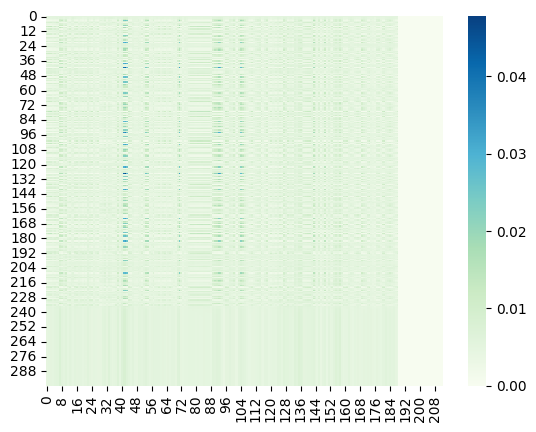

Train loss 0.0331%	 Val dist 172.7751
Learning Rate 0.0002%	
Saving model

Epoch: 2/100


Val:   3%|▎         | 1/29 [00:01<00:46,  1.67s/it, dist=165.7812]


Ground Truth :  IN A MOMENT PEGGY WAS ON THE STAGE AGAIN AND ALEXANDER APPLAUDED VIGOROUSLY WITH THE REST
Prediction   :  AANN  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA


Val:   7%|▋         | 2/29 [00:03<00:40,  1.51s/it, dist=166.9479]


Ground Truth :  THE ZEAL OF CYRIL EXPOSED HIM TO THE PENALTIES OF THE JULIAN LAW BUT IN A FEEBLE GOVERNMENT AND A SUPERSTITIOUS AGE HE WAS SECURE OF IMPUNITY AND EVEN OF PRAISE
Prediction   :  AANN  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TTHHEE  HHAA  TT


Val:  10%|█         | 3/29 [00:04<00:39,  1.50s/it, dist=169.5868]


Ground Truth :  THE LEMON WAS FIRST CULTIVATED IN ENGLAND IN THE BEGINNING OF THE SEVENTEENTH CENTURY AND IS NOW OFTEN TO BE FOUND IN OUR GREEN HOUSES
Prediction   :  AANN  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS


Val:  14%|█▍        | 4/29 [00:05<00:36,  1.47s/it, dist=168.6328]


Ground Truth :  I EXPLAIN THAT I'M TAKING MUSIC AND ALSO BIOLOGY ALGEBRA ENGLISH AND FRENCH MUSIC HE SNORTS
Prediction   :  AANN  TTHHEE  HHAA  SS  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  


Val:  17%|█▋        | 5/29 [00:07<00:35,  1.47s/it, dist=168.2833]


Ground Truth :  HE COULD STAND RIGHT UP AND TALK TO YOU HE COULD DID HE FIGHT HARD
Prediction   :  IINN  TTHHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  


Val:  21%|██        | 6/29 [00:08<00:33,  1.46s/it, dist=170.5052]


Ground Truth :  HE SAYS THAT BY CUTTING THROUGH FOUR OR FIVE SLICES AT A TIME ALL THE BUTTER IS SQUEEZED OUT OF THE UPPER ONES WHILE THE BOTTOM ONE IS SWIMMING IN FAT LIQUID
Prediction   :  AANN  TTHHEE  SS  AA  MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


Val:  24%|██▍       | 7/29 [00:10<00:32,  1.46s/it, dist=170.2307]


Ground Truth :  HE WAS IN A FEVERED STATE OF MIND OWING TO THE BLIGHT HIS WIFE'S ACTION THREATENED TO CAST UPON HIS ENTIRE FUTURE
Prediction   :  AANN  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA


Val:  28%|██▊       | 8/29 [00:11<00:30,  1.44s/it, dist=169.6745]


Ground Truth :  I WAS TO SEE THE SHEEP NOT NECESSARILY CLOSE AT HAND NOR TO GET THEM IN A SINGLE MOB BUT TO SEE ENOUGH OF THEM HERE AND THERE TO FEEL EASY THAT NOTHING HAD GONE WRONG THIS WAS NO DIFFICULT MATTER FOR THERE WERE NOT ABOVE EIGHT HUNDRED OF THEM AND BEING ALL BREEDING EWES THEY WERE PRETTY QUIET
Prediction   :  AANN  TTHHEE  AA  AA  MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


Val:  31%|███       | 9/29 [00:13<00:27,  1.40s/it, dist=168.3634]


Ground Truth :  IT TURNED OUT THAT SHE HAD A LITTLE MONEY OF HER OWN ABOUT A HUNDRED AND THIRTY POUNDS A YEAR
Prediction   :  IINN  TTHHEE  SS  AA  MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


Val:  34%|███▍      | 10/29 [00:14<00:25,  1.37s/it, dist=167.8146]


Ground Truth :  HE SMILED GUILTILY AS HE ADDED BUT I MUST ADMIT I WAS MORE THAN A LITTLE CONCERNED MYSELF
Prediction   :  AANN  TTHHEE  SS  AA  MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


Val:  38%|███▊      | 11/29 [00:15<00:25,  1.42s/it, dist=169.5928]


Ground Truth :  NOT THAT SUCH A CREATURE AS THAT DISTURBS ME NO CREATED THING I HOPE CAN MOVE MY EQUANIMITY BUT IF I COULD STOOP TO HATE I SHOULD HATE HER HATE HER
Prediction   :  AANN  TTHHEE  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA


Val:  41%|████▏     | 12/29 [00:17<00:24,  1.43s/it, dist=169.6649]


Ground Truth :  THIS SWEETWATER AS THEY CALLED HIM WAS I HAVE SINCE UNDERSTOOD ONE OF HIS PROTEGES AND MORE OR LESS OF A FAVOURITE
Prediction   :  AANN  TTHHEE  SS  PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP


Val:  45%|████▍     | 13/29 [00:18<00:22,  1.43s/it, dist=170.3149]


Ground Truth :  YET DID THE WATCHFUL MISS WOODLEY OFTENTIMES HEAR A SIGH ESCAPE FROM HER UNKNOWN TO HERSELF TILL SHE WAS REMINDED OF IT AND THEN A SUDDEN BLUSH WOULD INSTANTLY OVERSPREAD HER FACE
Prediction   :  IINN  TTHHEE  SS  AA  MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


Val:  48%|████▊     | 14/29 [00:20<00:21,  1.46s/it, dist=170.6585]


Ground Truth :  WHAT LED ME INTO IT WAS A CERTAIN THIRST FOR VENGEANCE WHICH IS STRONG ENOUGH TO DISTURB THE QUIETEST HEARTS
Prediction   :  IINN  TTHHEE  SS  AA  MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


Val:  52%|█████▏    | 15/29 [00:21<00:19,  1.40s/it, dist=170.1264]


Ground Truth :  I'LL REPORT THIS TO THE GOVERNMENT
Prediction   :  AANN  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA


Val:  55%|█████▌    | 16/29 [00:23<00:19,  1.47s/it, dist=171.5820]


Ground Truth :  OCCASIONALLY TOO THE WAKING CALL COMES TOO LATE THE CHANCE WHICH GIVES PERMISSION TO TAKE ACTION WHEN THEIR BEST YOUTH AND STRENGTH FOR ACTION HAVE BEEN USED UP IN SITTING STILL AND HOW MANY A ONE JUST AS HE SPRANG UP HAS FOUND WITH HORROR THAT HIS LIMBS ARE BENUMBED AND HIS SPIRITS ARE NOW TOO HEAVY
Prediction   :  AANN  TTHHEE  SS  AA  MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


Val:  59%|█████▊    | 17/29 [00:24<00:17,  1.49s/it, dist=171.6691]


Ground Truth :  WHEN SHE FELL THE WHOLE RACE FELL WITH HER
Prediction   :  AANN  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA


Val:  62%|██████▏   | 18/29 [00:26<00:16,  1.48s/it, dist=171.0359]


Ground Truth :  A MAN IN THE WELL
Prediction   :  AANN  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS  AA  SS


Val:  66%|██████▌   | 19/29 [00:27<00:14,  1.41s/it, dist=170.4567]


Ground Truth :  HE WOULD MAKE A FAMOUS SCOUNDREL
Prediction   :  IINN  TTHHEE  SS  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC


Val:  69%|██████▉   | 20/29 [00:28<00:12,  1.39s/it, dist=169.8495]


Ground Truth :  WE NEED KENTUCKY AND I UNDERSTAND THAT A VERY LITTLE MORE MAY BRING THE STATE TO US GO WITH YOUR FATHER I UNDERSTAND THAT YOU HAVE BEEN A BRAVE YOUNG SOLDIER HERE AND MAY YOU DO AS WELL UP THERE
Prediction   :  AANN  TTHHEE  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA  AA


Val:  72%|███████▏  | 21/29 [00:30<00:10,  1.36s/it, dist=169.4182]


Ground Truth :  I RECKON THERE ARE SMILED THE GUIDE WE ARE IN THE BEAR COUNTRY NOW
Prediction   :  IINN  TTHHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  


Val:  76%|███████▌  | 22/29 [00:31<00:09,  1.36s/it, dist=168.9384]


Ground Truth :  NOW FIFTEEN YEARS AFTER THE PRINCESS WAS BORN SHE WAS WITH THE KING AND QUEEN AT ONE OF THEIR CASTLES AND AS SHE WAS RUNNING ABOUT BY HERSELF SHE CAME TO A LITTLE CHAMBER AT THE TOP OF A TOWER AND THERE SAT AN HONEST OLD WOMAN SPINNING FOR SHE HAD NEVER HEARD OF THE KING'S EDICT
Prediction   :  IINN  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TTHHEE  SS  TT


Val:  79%|███████▉  | 23/29 [00:32<00:08,  1.37s/it, dist=168.4774]


Ground Truth :  SERVE WITH FRENCH DRESSING HIDDEN UNDER THE LEAVES OF THE NEST
Prediction   :  BBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBBB


Val:  83%|████████▎ | 24/29 [00:34<00:06,  1.37s/it, dist=168.1332]


Ground Truth :  HIS OWN SKIN HAD SIZZLED UNDER THE RED HOT BRAND HE MURMURED SOFTLY
Prediction   :  AANN  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS


Val:  86%|████████▌ | 25/29 [00:35<00:05,  1.36s/it, dist=167.5646]


Ground Truth :  WELL OUR LOWER LIPS ANYWAY ANSWERED THE NYMPH
Prediction   :  IINN  AA  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE  HHEE


Val:  90%|████████▉ | 26/29 [00:36<00:04,  1.36s/it, dist=167.6162]


Ground Truth :  WE ARE GOING INTO THE FOREST TO HEW WOOD AND IN THE EVENING WHEN WE ARE READY WE WILL COME AND FETCH YOU AGAIN
Prediction   :  AANN  TTHHEE  AA  MMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMMM


Val:  93%|█████████▎| 27/29 [00:38<00:02,  1.37s/it, dist=167.2076]


Ground Truth :  OH YOU RAVE SIR EXCLAIMED VILLEFORT IN VAIN ENDEAVORING TO ESCAPE THE NET IN WHICH HE WAS TAKEN I RAVE
Prediction   :  IINN  TTHHEE  CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC



Ground Truth :  AND IN HIS SPEECH HE LAUGH'D AND LAUGH'D AGAIN THEN WHILE IT WAS HIS PLEASURE TO REMAIN I CHANCED TO LOOK THE WAY HE HAD DRAWN NEAR AND SAW THE LADIES JOAN AND BEATRICE APPROACH ME THIS THE OTHER FOLLOWING ONE AND A SECOND MARVEL INSTANTLY
Prediction   :  AANN  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS  AA  TTHHEE  SS


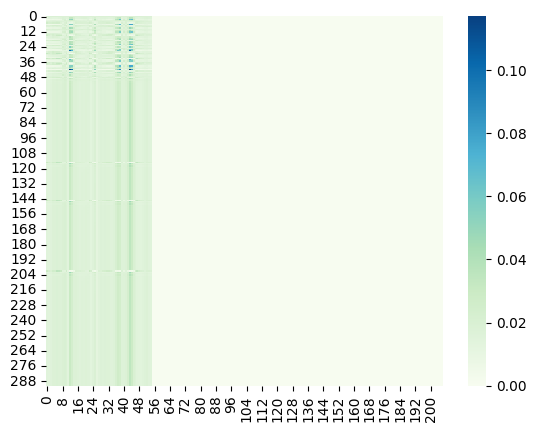

Train loss 0.0457%	 Val dist 161.4077
Learning Rate 0.0002%	
Saving model

Epoch: 3/100


Train:   5%|▌         | 16/298 [00:23<06:40,  1.42s/it, loss=0.0624, lr=0.0002, perplexity=1.0646, tf_rate=0.97]

KeyboardInterrupt: ignored

In [41]:
best_lev_dist = float("inf")
tf_decay = 0.99
tf = 1.0

for epoch in range(0, config['epochs']):

    print("\nEpoch: {}/{}".format(epoch+1, config['epochs']))
    tf = max(tf * tf_decay, 0.2)
    curr_lr = float(optimizer.param_groups[0]['lr'])

    # Call train and validate, get attention weights from training
    running_loss, running_perplexity, attention_plot = train(model, train_loader, criterion, optimizer, tf)
    valid_dist = validate(model, valid_loader)

    # Print your metrics

    # Plot Attention for a single item in the batch
    plot_attention(attention_plot[0].cpu().detach().numpy())

    # Log metrics to Wandb
    print("Train loss {:.04f}%\t Val dist {:.04f}".format(running_loss, valid_dist))
    print("Learning Rate {:.04f}%\t".format(curr_lr))

    wandb.log({"train_loss_running":running_loss, 'validation_dist':valid_dist,
               "learning_Rate": curr_lr})

    # Optional: Scheduler Step / Teacher Force Schedule Step
    scheduler.step(running_loss)

    if valid_dist <= best_lev_dist:
        best_lev_dist = valid_dist
        print("Saving model")
        # save locally
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_dist': valid_dist,
                    'epoch': epoch}, './checkpoint.pth')
        # save in drive as well
        torch.save({'model_state_dict':model.state_dict(),
                    'optimizer_state_dict':optimizer.state_dict(),
                    'scheduler_state_dict':scheduler.state_dict(),
                    'val_dist': valid_dist,
                    'epoch': epoch}, checkpoint_path)

        best_lev_dist = valid_dist
        # save in wandb
        wandb.save('checkpoint.pth')
        # You may find it interesting to exlplore Wandb Artifcats to version your models

# Testing

In [1]:
# Optional: Load your best model Checkpoint here

# TODO: Create a testing function similar to validation
# TODO: Create a file with all predictions
# TODO: Submit to Kaggle